<a href="https://colab.research.google.com/github/igornunespatricio/transfer-learning-catsdogs/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning / fine-tuning

This tutorial will guide you through the process of using _transfer learning_ to learn an accurate image classifier from a relatively small number of training samples. Generally speaking, transfer learning refers to the process of leveraging the knowledge learned in one model for the training of another model.

More specifically, the process involves taking an existing neural network which was previously trained to good performance on a larger dataset, and using it as the basis for a new model which leverages that previous network's accuracy for a new task. This method has become popular in recent years to improve the performance of a neural net trained on a small dataset; the intuition is that the new dataset may be too small to train to good performance by itself, but we know that most neural nets trained to learn image features often learn similar features anyway, especially at early layers where they are more generic (edge detectors, blobs, and so on).

Transfer learning has been largely enabled by the open-sourcing of state-of-the-art models; for the top performing models in image classification tasks (like from [ILSVRC](http://www.image-net.org/challenges/LSVRC/)), it is common practice now to not only publish the architecture, but to release the trained weights of the model as well. This lets amateurs use these top image classifiers to boost the performance of their own task-specific models.

#### Feature extraction vs. fine-tuning

At one extreme, transfer learning can involve taking the pre-trained network and freezing the weights, and using one of its hidden layers (usually the last one) as a feature extractor, using those features as the input to a smaller neural net.

At the other extreme, we start with the pre-trained network, but we allow some of the weights (usually the last layer or last few layers) to be modified. Another name for this procedure is called "fine-tuning" because we are slightly adjusting the pre-trained net's weights to the new task. We usually train such a network with a lower learning rate, since we expect the features are already relatively good and do not need to be changed too much.

Sometimes, we do something in-between: Freeze just the early/generic layers, but fine-tune the later layers. Which strategy is best depends on the size of your dataset, the number of classes, and how much it resembles the dataset the previous model was trained on (and thus, whether it can benefit from the same learned feature extractors). A more detailed discussion of how to strategize can be found in [[1]](http://cs231n.github.io/transfer-learning/) [[2]](http://sebastianruder.com/transfer-learning/).

## Procedure

In this guide will go through the process of loading a state-of-the-art, 1000-class image classifier, [VGG16](https://arxiv.org/pdf/1409.1556.pdf) which [won the ImageNet challenge in 2014](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), and using it as a fixed feature extractor to train a smaller custom classifier on our own images, although with very few code changes, you can try fine-tuning as well.

We will first load VGG16 and remove its final layer, the 1000-class softmax classification layer specific to ImageNet, and replace it with a new classification layer for the classes we are training over. We will then freeze all the weights in the network except the new ones connecting to the new classification layer, and then train the new classification layer over our new dataset.

We will also compare this method to training a small neural network from scratch on the new dataset, and as we shall see, it will dramatically improve our accuracy. We will do that part first.

As our test subject, we'll use a dataset consisting of around 6000 images belonging to 97 classes, and train an image classifier with around 80% accuracy on it. It's worth noting that this strategy scales well to image sets where you may have even just a couple hundred or less images. Its performance will be lesser from a small number of samples (depending on classes) as usual, but still impressive considering the usual constraints.


In [ ]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from tqdm import tqdm

### Dataset

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  70.8M      0  0:00:11  0:00:11 --:--:-- 85.3M


In [ ]:
!unzip /content/kagglecatsanddogs_5340.zip -d /content/catsdogs > /dev/null

In [ ]:
!find catsdogs -type d

catsdogs
catsdogs/PetImages
catsdogs/PetImages/Dog
catsdogs/PetImages/Cat


In [ ]:
import os
import warnings
import logging
from tqdm import tqdm
from tensorflow.keras.utils import img_to_array, load_img

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Custom function to check if the image can be opened
def is_valid_image(file_path):
    try:
        # Temporarily suppress warnings to avoid progress bar disruption
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            img = load_img(file_path)  # Try to open the image file
            img_to_array(img)          # Try to convert it to an array
        return True
    except (IOError, OSError, ValueError):
        return False

# Clean the dataset by filtering out corrupted images
def clean_dataset(directory):
    # Initialize tqdm progress bar with a count of all files
    total_files = sum(len(files) for _, _, files in os.walk(directory))

    with tqdm(total=total_files, desc="Checking images for corruption", ncols=100) as pbar:
        for root, dirs, files in os.walk(directory):
            for file in files:
                file_path = os.path.join(root, file)
                if not is_valid_image(file_path):
                    # Log the removal of corrupted images instead of printing
                    logging.info(f"Corrupted image detected and removed: {file_path}")
                    os.remove(file_path)
                # Update progress bar
                pbar.update(1)

# Clean your dataset directories
clean_dataset('catsdogs/PetImages')


Checking images for corruption: 100%|████████████████████████| 25002/25002 [00:46<00:00, 540.68it/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories for training, validation, and testing
base_dir = 'catsdogs/PetImages'
train_dir = base_dir  # You can split the data into subdirectories if needed

# Define parameters
img_size = (224, 224)  # Target image size
batch_size = 32        # Number of images per batch

# Create ImageDataGenerator instances for train, validation, and test
train_datagen = ImageDataGenerator(
    rescale=1.0/255,          # Rescale pixel values to [0, 1]
    validation_split=0.2      # Use 20% of data for validation
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',      # Binary classification: Dog vs Cat
    subset='training'         # Use 80% of data for training
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'       # Use 20% of data for validation
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


### First training a neural net from scratch

Baseline network to compare with transfer learning.

In [ ]:
# Build the network
model = Sequential()

# Use an Input layer with the additional dimension for channels (e.g., 3 for RGB)
model.add(Input(shape=img_size + (3,)))  # Add the channel dimension directly here
print("Input dimensions: ", img_size + (3,))  # Display the adjusted input dimensions

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

# Use `num_classes` dynamically determined from your data
num_classes = 2  # Adjust if you have more classes
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Display the model architecture
model.summary()

Input dimensions:  (224, 224, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

We've created a medium-sized network with ~1.2 million weights and biases (the parameters). Most of them are leading into the one pre-softmax fully-connected layer "dense_5".

We can now go ahead and train our model for 100 epochs with a batch size of 128. We'll also record its history so we can plot the loss over time later.

In [ ]:
# Compile the model for multi-class classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the generators
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


231/625 ━━━━━━━━━━━━━━━━━━━━ 31s 81ms/step - accuracy: 0.5370 - loss: 0.6877

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 99ms/step - accuracy: 0.5772 - loss: 0.6630 - val_accuracy: 0.6883 - val_loss: 0.5896
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 95ms/step - accuracy: 0.7337 - loss: 0.5293 - val_accuracy: 0.7505 - val_loss: 0.4955
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - accuracy: 0.7806 - loss: 0.4578 - val_accuracy: 0.7969 - val_loss: 0.4523
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 93ms/step - accuracy: 0.8132 - loss: 0.4099 - val_accuracy: 0.8033 - val_loss: 0.4242
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.8355 - loss: 0.3684 - val_accuracy: 0.8245 - val_loss: 0.3801
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 90ms/step - accuracy: 0.8490 - loss: 0.3448 - val_accuracy: 0.8445 - val_loss: 0.3436
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - accuracy: 0.8708 - loss: 0.3036 - val_accuracy: 0.8549 - val_loss: 0.3309
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - accuracy: 0.8809 - loss: 0.2797 - val_accurac

Let's plot the validation loss and validation accuracy over time.

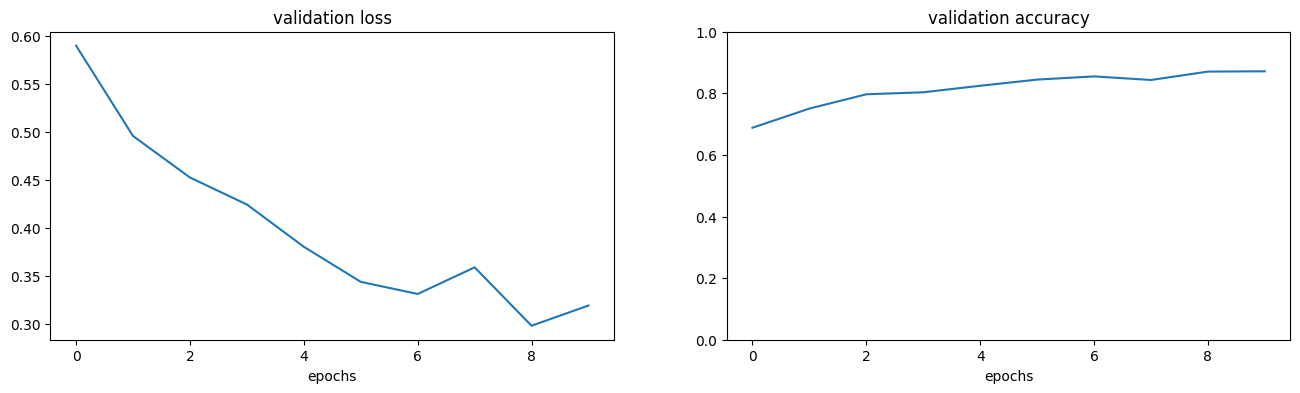

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

### VGG 16 Transfer Learning

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


In [ ]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [ ]:
history2 = model_new.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)


Epoch 1/10
 96/625 ━━━━━━━━━━━━━━━━━━━━ 1:18 149ms/step - accuracy: 0.6338 - loss: 0.6859

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 138s 189ms/step - accuracy: 0.7843 - loss: 0.4422 - val_accuracy: 0.9010 - val_loss: 0.2450
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 112s 178ms/step - accuracy: 0.8851 - loss: 0.2637 - val_accuracy: 0.8802 - val_loss: 0.2724
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 182ms/step - accuracy: 0.8893 - loss: 0.2553 - val_accuracy: 0.8984 - val_loss: 0.2433
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 159s 210ms/step - accuracy: 0.9004 - loss: 0.2321 - val_accuracy: 0.9066 - val_loss: 0.2200
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 113s 181ms/step - accuracy: 0.9020 - loss: 0.2260 - val_accuracy: 0.9104 - val_loss: 0.2128
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 112s 179ms/step - accuracy: 0.9060 - loss: 0.2254 - val_accuracy: 0.9166 - val_loss: 0.2061
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 112s 179ms/step - accuracy: 0.9110 - loss: 0.2060 - val_accuracy: 0.9152 - val_loss: 0.2060
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 180ms/step - accuracy: 0.9004 - loss: 0.23

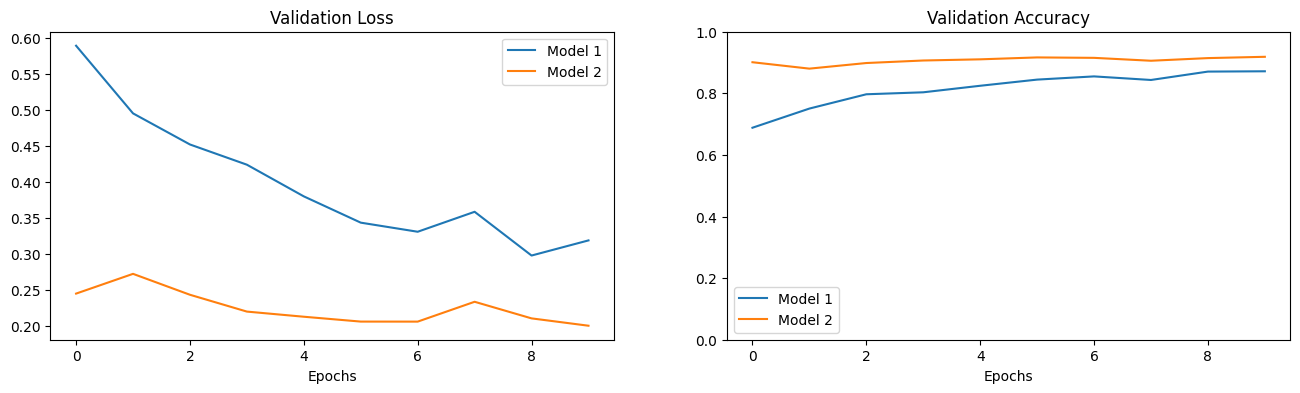

In [ ]:
import matplotlib.pyplot as plt

# Create the figure and subplots
fig = plt.figure(figsize=(16, 4))

# Plot for validation loss
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"], label="Model 1")  # Add label for history
ax.plot(history2.history["val_loss"], label="Model 2")  # Add label for history2
ax.set_title("Validation Loss")
ax.set_xlabel("Epochs")
ax.legend()  # Add legend to the first subplot

# Plot for validation accuracy
ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"], label="Model 1")  # Add label for history
ax2.plot(history2.history["val_accuracy"], label="Model 2")  # Add label for history2
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylim(0, 1)
ax2.legend()  # Add legend to the second subplot

# Display the plot
plt.show()
